# Analysis of FOCI-OpenIFS-2.1-ORCA12

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## En dask i ändan

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [42]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit=96e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38623 instead
  expected, actual


In [43]:
client

Client Scheduler: tcp://127.0.0.1:36309 Dashboard: http://127.0.0.1:38623/status,Cluster Workers: 8 Cores: 16 Memory: 715.26 GiB


## Read ORCA12 mesh

In [30]:
bfile = '/gxfs_work1/geomar/smomw352/bathymetry_ORCA12_V3.3.nc'
dsb = xr.open_dataset(bfile,decode_times=False)
da_orca12_bathy = dsb['Bathymetry']

cfile = '/gxfs_work1/geomar/smomw352/orca12_coordinates.nc'
dsc = xr.open_dataset(cfile,decode_times=False)
da_orca12_dxt = dsc['e1t'].squeeze(drop=True)
da_orca12_dyt = dsc['e2t'].squeeze(drop=True)
da_orca12_tarea = da_orca12_dxt * da_orca12_dyt

In [31]:
da_orca12_tarea

<xarray.DataArray (y: 3059, x: 4322)>
array([[4.33837030e+06, 4.33837030e+06, 4.33837030e+06, ...,
        4.33837030e+06, 4.33837030e+06, 4.33837030e+06],
       [4.35068383e+06, 4.35068383e+06, 4.35068383e+06, ...,
        4.35068383e+06, 4.35068383e+06, 4.35068383e+06],
       [4.36303200e+06, 4.36303200e+06, 4.36303200e+06, ...,
        4.36303200e+06, 4.36303200e+06, 4.36303200e+06],
       ...,
       [2.60772135e+03, 3.96432120e+01, 3.11167740e+03, ...,
        3.12633844e+03, 2.60772135e+03, 3.96432120e+01],
       [2.18179728e+03, 4.95174837e+01, 3.81565733e+03, ...,
        3.81505769e+03, 2.18179728e+03, 4.95174837e+01],
       [2.74519404e+03, 3.32983937e+01, 2.24098055e+03, ...,
        2.76110678e+03, 2.74519404e+03, 3.32983937e+01]])
Dimensions without coordinates: y, x

## Read monthly T files (with budget terms)

In [7]:
esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
exp = 'FOCI_BJK017'
times = slice('1950-01-01','1952-12-31')

In [11]:
# NEMO derived
ds_t_1m = []

if 1:
    t = '/%s/%s/outdata/nemo/%s*1m*grid_T.nc' % (esmdir,exp,exp)
    print(t)
    ds_t = xr.open_mfdataset(t,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=times)
    ds_t_1m.append(ds_t)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_BJK017/outdata/nemo/FOCI_BJK017*1m*grid_T.nc


In [12]:
ds_t_1m = xr.concat(ds_t_1m, compat='equals', dim='time')

In [18]:
# Gives chunks of approx 300 Mb
ds_t_1m = ds_t_1m.chunk({'x':1000, 'y': 1000, 'deptht':75, 'time':1})

In [19]:
ds_t_1m

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 75, time: 35, x: 4322, y: 3059)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) object 1950-02-15 00:00:00 ... 1952-12-16 12...
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/35)
    deptht_bounds         (time, deptht, axis_nbounds) float32 dask.array<chunksize=(1, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    ttrd_xad              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    strd_xad              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    ttrd_yad              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    ...                    ...
    ttrd_qns              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    strd_cdt              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    ttrd_qsr              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    ttrd_bbc              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    ttrd_atf              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
    strd_atf              (time, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1000, 1000), meta=np.ndarray>
Attributes:
    name:         FOCI_BJK017_1m_19500201_19500228_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Jul-06 19:14:51 GMT
    uuid:         32e441e4-8742-48dc-a21d-7c87247cff0e
    history:      Wed Jul 13 07:45:27 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...

## Horizontally integrated budgets

$$
\frac{\partial T}{\partial t} = \underbrace{- \frac{\partial T}{\partial x}}_{\verb|ttrd_xad|} - \underbrace{\frac{\partial T}{\partial y}}_{\verb|ttrd_yad|} - \underbrace{\frac{\partial T}{\partial z}}_{\verb|ttrd_zad|} + \underbrace{D^T}_{\verb|ttrd_ldf| + \verb|ttrd_zdf|} + \underbrace{F^T}_{\verb|ttrd_qsr| + \verb|ttrd_qns|}
$$

In [23]:
x_slice = slice(0,4322)
y_slice = slice(0,3059)

In [36]:
# Do this once, so we don't have to do it all the time
da_orca12_totarea = da_orca12_tarea.sum(('x','y'))
print(da_orca12_totarea.values)

503851299637455.9


In [52]:
budget_terms = ['xad', 'yad', 'zad', 'ldf', 'zdf', 'qsr', 'qns']
h_int = []

for b in budget_terms:
    tb = 'ttrd_%s' % (b,)
    
    # This computes global budget also over land
    # We should do this with a proper 3D mask
    _area = da_orca12_tarea.chunk({'x':1000, 'y': 1000})
    tb_sum = (ds_t_1m[tb].sel(x=x_slice, y=y_slice) * _area).sum(('x','y'))
    tb_int = tb_sum / da_orca12_totarea
    
    print(tb_int)
    h_int.append(tb_int.compute())

<xarray.DataArray (time: 35, deptht: 75)>
dask.array<truediv, shape=(35, 75), dtype=float64, chunksize=(1, 75), chunktype=numpy.ndarray>
Coordinates:
  * deptht         (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) object 1950-02-15 00:00:00 ... 1952-12-16 12:00:00
<xarray.DataArray (time: 35, deptht: 75)>
dask.array<truediv, shape=(35, 75), dtype=float64, chunksize=(1, 75), chunktype=numpy.ndarray>
Coordinates:
  * deptht         (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) object 1950-02-15 00:00:00 ... 1952-12-16 12:00:00
<xarray.DataArray (time: 35, deptht: 75)>
dask.array<truediv, shape=(35, 75), dtype=float64, chunksize=(1, 75), chunktype=numpy.ndarray>
Coordinates:
  * deptht         (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    t

In [54]:
# Add xad, yad and zad to ad
budget_terms.append('ad')
h_int.append( h_int[0] + h_int[1] + h_int[2])

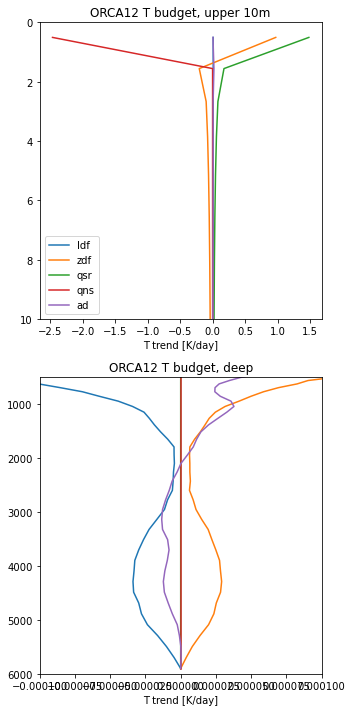

In [67]:
fig1, ax1 = plt.subplots(2,1, figsize=(5,10))

for (tb_int, b) in zip(h_int[3:], budget_terms[3:]):
    
    scale = 86400 # K/s -> K/day
    ax1[0].plot(tb_int.mean('time') * scale, tb_int.deptht, label=b)
    ax1[1].plot(tb_int.mean('time') * scale, tb_int.deptht, label=b)

ax1[0].set_ylim(0,10)
ax1[1].set_xlim([-1e-4,1e-4])
ax1[1].set_ylim(500,6000)

ax1[0].set_title('ORCA12 T budget, upper 10m')
ax1[1].set_title('ORCA12 T budget, deep')
ax1[0].legend()

for ax in ax1:
    ax.invert_yaxis()
    ax.set_xlabel('T trend [K/day]')
    
fig1.tight_layout()
fig1.savefig('t_vertical_budget.pdf',format='pdf')